In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Recap

The workflow we have been working with, consists of:

1. load data
2. visualise data 
3. prepare data
4. test models (hyperparameter tuning)

Let's walk through all of that really fast as a recap

## 1.1 Explore the data

In [2]:
# df = sns.load_dataset("iris")
# df.head()
data = sns.load_dataset("penguins")
df = data.drop(["island", "sex"], axis=1).dropna()
y = df["species"]
X = df.drop("species", axis=1)
df.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


<AxesSubplot: xlabel='bill_length_mm', ylabel='bill_depth_mm'>

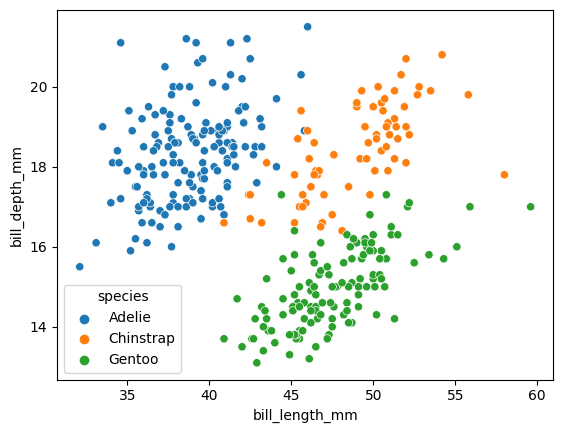

In [3]:
sns.scatterplot(data=df, x="bill_length_mm", y="bill_depth_mm", hue="species")

<AxesSubplot: xlabel='variable', ylabel='value'>

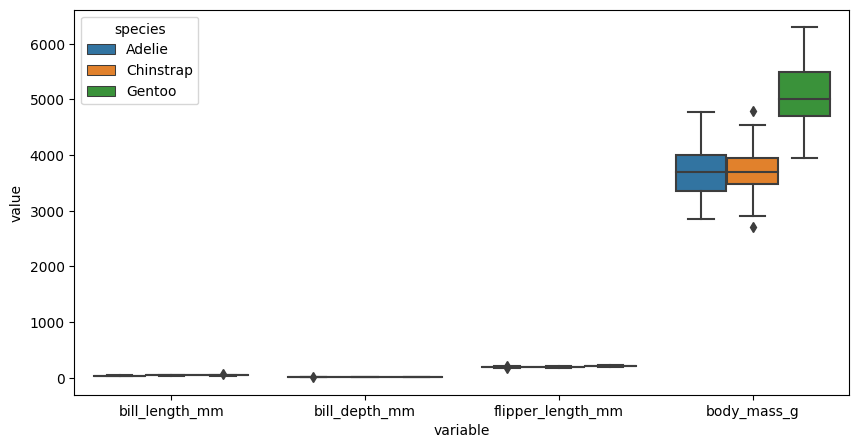

In [4]:
p = df.melt(id_vars = 'species')
plt.figure(figsize=(10,5))
sns.boxplot(data = p, x = 'variable', y='value', hue='species')

## 1.2. Prepare the data

In [5]:
from sklearn.model_selection import train_test_split
X = df.drop('species', axis=1)
y = df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<AxesSubplot: xlabel='variable', ylabel='value'>

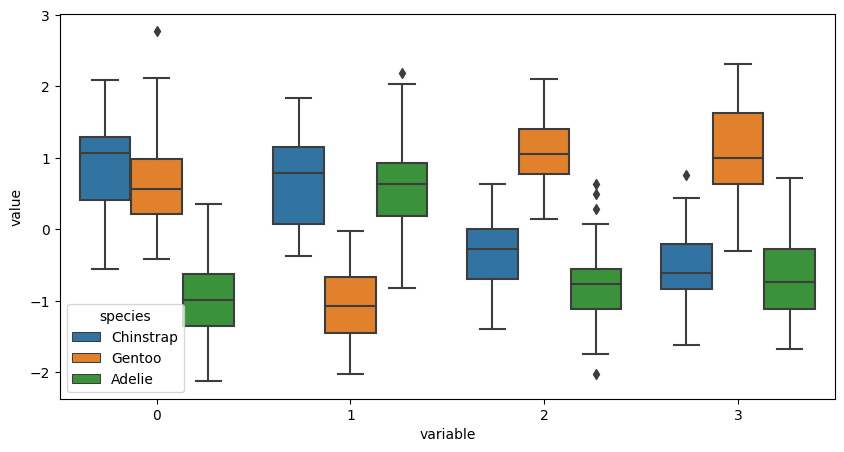

In [7]:
p = pd.DataFrame(X_train, y_train).reset_index()
p = p.melt(id_vars = 'species')
plt.figure(figsize=(10,5))
sns.boxplot(data = p, x = 'variable', y='value', hue='species')

## 1.3. Pick hyperparameters and fit a model

We pick a lot of different classifiers

In [8]:
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

And test them

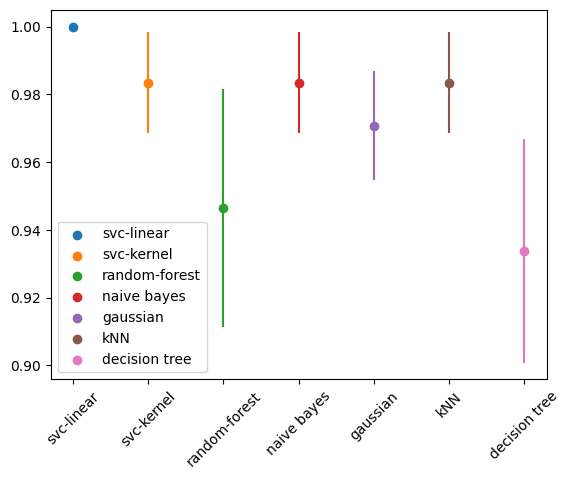

In [9]:
cv = 5
classifiers = [
    ('svc-linear', SVC(kernel='linear')),
    ('svc-kernel', SVC(C=1.0)),
    ('random-forest', RandomForestClassifier(n_estimators=100)),
    ('naive bayes', GaussianNB()),
    ('gaussian', GaussianProcessClassifier()),
    ('kNN', KNeighborsClassifier(n_neighbors=5)),
    ('decision tree', DecisionTreeClassifier(criterion='gini'))
]

for i, (name, clf) in enumerate(classifiers):
    clf.fit(X_train, y_train)
    result = cross_val_score(clf, X_test, y_test, cv = cv, scoring='f1_macro')
    
    mu = np.mean(result)
    stderr = np.std(result)/np.sqrt(cv)

    plt.scatter(i, mu, label=name)
    plt.errorbar(i, mu, yerr=stderr)
    plt.legend(loc=3)

plt.xticks(np.arange(len(classifiers)), [name[0] for name in classifiers], rotation=45);
plt.show()

## 1.4. Evaluate the model

In [10]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)

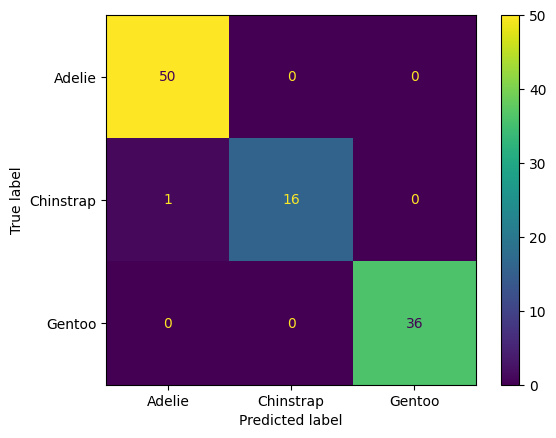

In [11]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
cfm = confusion_matrix(y_test, yhat)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [12]:
score = f1_score(y_test, yhat, average="macro")
score

0.9865986598659866

# 2. Gridsearch & Pipelines

While this is a basic approach, that can certainly give you results, there are some things that can be improved.

- We just picked a model without changing the default hyperparameters. Hypertuning them can really improve a model
- There are a lot of places that can give mistakes, especially if we make more complex models with multiple steps. We can make our approach more solid by specifying the order.
- There are a lot of basic steps that we always need to repeat in the same order. This can be reduced into an efficient function.

So, while we still keep these steps:

1. explore data
2. prepare data (eg rescaling, reshaping)
3. pick hyperparameters and fit the model
4. evaluate the model

It is a good practice to bundle both step 2. and 3. into pipelines. Let's start with step 3, the picking of the best hyperparameters for a model.

## 2.1.1 Basic hyperparameter tuning

Hyperparameter tuning basically comes down to answering the question: what is the optimal combination of parameters for my problem? 

We already tried this with list comprehension, to quickly create a range of powers of 10.

While that worked, we have to multiply the amount of parameters to calculate the size of the searchspace. 

So, considering seven different values for two hyperparameters, we are searching $7*7=49$ combinations.

## 2.1.2 Exhaustive gridsearch & heatmaps
We will both use `GridSearchCV` to improve our hyperparameter tuning, and heatmaps to improve the evaluation.

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [10**x for x in range(-4,3)],
              'gamma': [10**x for x in range(-4,3)]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'C': 10, 'gamma': 1}

This already has a lot of advantages. We can easily expand the amount of parameters to check. We use a lot less code. You are protected against making all sorts of errors. And you use cross validation, which can be coded by hand too, but will take even more code. 

The question now is: was this a good gridsearch? There is a lot of room between a value C=10 and C=100.

The best approach is to do itterations:

Initially, you start with a scale that uses powers of 10 to quickly sweep a big area. Why not check the whole range to start with? Well, you have to consider the size of the space you are searching. Testing with a granularity of 0.0001 over the range 0.0001 up till 100 will take way too much time, especially if we have to multiply the range of every hyperparameter.

So, start big, and zoom in. You can finetune the values by using heatmaps (at least, for the 2D case).

## 2.1.2 Random Gridsearch & successive halving

If the searchspace becomes too large to search with a grid, you can take several approaches.

Because our trainingset is very small, the overhead of the halving makes things worse, but for large datasets this can actually be a smart way to decrease time. To show this, let's make a new dummy dataset with 1000 examples.

The first is to use a random grid search, where you can define distributions over which hyperparameters are randomly sampled. You can combine this with lists (e.g. for the kernels)

First, a full gridsearch:

In [14]:
from time import time
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, random_state=42)


param_grid = {'C': [10**x for x in range(-4,3)],
              'gamma': [10**x for x in range(-4,3)],
              'kernel': ['rbf', 'poly']}
tic = time()
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X, y)
time_full = time()-tic

grid_search.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Then, a randomize search. Our initial searchspace had a size of $7*7*2=98$. We will now just sample 30 parameter settings, which is about 30%.

In [15]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
param_dist = {'C': stats.expon(scale=100), 'gamma': stats.expon(scale=.01),
  'kernel': ['rbf', 'poly']}

tic = time()
random_search = RandomizedSearchCV(SVC(), param_distributions=param_dist,
                                   n_iter=30, random_state=42)
random_search.fit(X, y)
time_random = time()-tic
random_search.best_params_

{'C': 40.602818331379076, 'gamma': 0.0015416196746656106, 'kernel': 'rbf'}

Another, more efficient, approach is to use successive halving. From the documentation:

>Successive halving (SH) is like a tournament among candidate parameter combinations. SH is an iterative selection process where all candidates (the parameter combinations) are evaluated with a small amount of resources at the first iteration. Only some of these candidates are selected for the next iteration, which will be allocated more resources. 

This approach is based on an interesting [paper](https://arxiv.org/abs/1603.06560)

We have a grid-version, that uses less training samples for the worse models. 

In [17]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
tic = time()          
sh = HalvingGridSearchCV(SVC(), param_grid, 
			cv=5,
                        factor=2)
sh.fit(X, y)
time_halving = time()-tic
sh.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

There also is a random version:

In [18]:
from sklearn.model_selection import HalvingRandomSearchCV
tic = time()          
sh = HalvingRandomSearchCV(SVC(), param_dist, 
			cv=5,
      factor=2,
      random_state=42)
sh.fit(X, y)
time_randomhalving = time()-tic
sh.best_params_

{'C': 40.602818331379076, 'gamma': 0.0015416196746656106, 'kernel': 'rbf'}

In [19]:
time_full, time_random, time_halving, time_randomhalving

(6.15762186050415, 1.7120277881622314, 0.7560462951660156, 0.39988088607788086)

It's obvious that a smart choice of searching the hyperparameter space can save you a lot of time. There is always a tradeoff with accuracy, however. It depends on the type of problem and the resources at hand (in terms of both hardware and time available) what is the best choice for problem.

# 2.2 Pipelines
We already introduced pipelines. Let's take some more time to get to know them.

Scikit-learn provides a lot of "transformers". These can do all sorts of things:

- Clean the data
- reduce the dimensions of the data
- feature generation (e.g. with text data)

Every transformer should have a `.fit`, `.transform` and `.fit_transform` method. This means that we could also create our own transformers, as long as they have these methods.

We can combine these steps into a `Pipeline`.
All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).


## 2.2.1 Gridsearch with a pipeline
The pipeline is a list of (key, value) pairs.

In [58]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([ 
	("scaler", StandardScaler()),
	("svc", SVC())
])
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

This will take care of things like the correct scaling on the trainset, without leaking information from the testset, and it is very easy to expand. We can add a lot of different steps into the pipeline without loosing track of the sequence.

With this in place, we can use the GridSearch like before. Only thing we need to change, is we need to tell specify for which step in the pipeline the hyperparameters are intended. We do that by adding the name of the step in front of the hyperparameters, separated by two underscores, like this "svc__C".

In [59]:
param_grid = {'svc__C': [10**x for x in range(-4,3)],
              'svc__gamma': [10**x for x in range(-4,3)]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]})

## 2.2.2 Preprocessing with a pipeline

Often, we need to transform our data. Let's imagine we have days of the weeks. To feed this into a model, we will usually need to transform this into a one-hot-encoding, where every day of the week has it's own column, and every column simly gets a value of 1 if it is that day of the week (hence the name).

In [60]:
from sklearn.preprocessing import OneHotEncoder
X = [["mon"], ["tue"], ["wed"], ["thu"]]
ohe = OneHotEncoder()
X_ = ohe.fit_transform(X)
X_.todense()

matrix([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])

This works as expected. Now let's make some imaginary data, where someone is selling icecream. The dataset has four days of observation, the temperature and the amount of icecreams sold.

In [61]:
X = [
	["mon", 20.4, 26], 
	["tue", 21.7, np.nan],
	["wed", 25.2, 55],
	["thu", 24.5, 48]
]
X = pd.DataFrame(X, columns=['day', 'temp', "icecream"])
X

,day,temp,icecream
0,mon,20.4,26.0
1,tue,21.7,NaN
2,wed,25.2,55.0
3,thu,24.5,48.0


Note that for one day, the amount of icecream sold is missing.

In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   day       4 non-null      object 
 1   temp      4 non-null      float64
 2   icecream  3 non-null      float64
dtypes: float64(2), object(1)
memory usage: 224.0+ bytes


For the seller to have profit, he needs to sell more than 30 icecreams. The last two days he made profit, so:

In [63]:
y = [0, 0, 1, 1]

Preprocessing the data, we would need to do a lot of things.
For example, we might want to impute the missing data. Let's say we want to take the median value for missing data.

Also, we would want to scale all the numeric data, and translate the categories into a one-hot-encoding.

Of course we could do this line by line, separarting and combining the data.

However, we can also use pipelines.

We start with specifying the types of columns

In [64]:
numeric = ["temp", "icecream"]
categories = ["day"]

We make two pipelines. One has the imputer and the scaler for the numeric data.
The other (consisting of just one step) is the one hot encoder.

We can now use the `Columntransformer` (which is a type of pipeline too) to combine the two transormers. Note that we use three values: a name, the transformer, and the columns to which we want to apply the transformers.

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categories)])

Lets test that!

In [65]:
preprocessor.fit_transform(X)

array([[-1.2941495 , -1.67165832,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.63438701,  0.34349144,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 1.14189662,  0.98467545,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.78663989,  0.34349144,  0.        ,  1.        ,  0.        ,
         0.        ]])

So, this is really nice. We have imputed the missing values, scaled everything, made a one-hot-encoding and stiched everything together!

Now, we can simply combine this step into another pipeline, where we feed this to a classifier

In [66]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

And with this, we can start doing everything we would want.
We can fit:

In [67]:
clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'icecream']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['day'])])),
                ('classifier', SVC())])

Predict

In [68]:
test = pd.DataFrame([["tue", 18.0, 14]], columns=['day', 'temp', "icecream"])
clf.predict(test)

array([0])

And hypertune. Note how we need to chain the names into a chain to specify the type of `strategy` for the `imputer`, inside the `num` step of the `preprocessor`.

In [69]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=2)
grid_search.fit(X, y)
grid_search.best_params_

{'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'}